# Method for calculating the number of blocks within buffered ranges of oil & gas facilities
This document walks through a method to calculate the number of populated census blocks within certain distances (0-250m, 250-500m, 500-750m, or 750-1000m) of an oil and gas facility. It leverages an overlay method, which derives the intersection between a set of buffers and a set of block in a fairly rapid fashion (<20 minutes for ~80,000 wells and ~100,000 blocks). It has the advantage of revealing where the closest *edge* of the block, rather than the centroid block, falls into the given distance range. It uses Colorado census block data and oil & gas data.

At the bottom of the document is a matrix-based method to quickly calculate the distance between oil & gas facilities and the *centroid* of blocks.

The methodology still needs to be double-checked and vetted. Specific questions are noted throughout.

#### Data

You will need the following data files in your directory: 


- [data/OIL_AND_GAS_LOCATIONS_SHP/Oil_and_Gas_Locations.shp](https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Oil_and_Gas_Locations_Metadata.html)
- [data/TANK_BATTERIES_SHP/Tank_Batteries.shp](https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Tank_Batteries_Metadata.html)
- [data/PITS_SHP/Pits.shp](https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Pits_Metadata.html)
- [data/tl_2019_08_tabblock10/tl_2019_08_tabblock10.shp](https://catalog.data.gov/dataset/tiger-line-shapefile-2019-2010-state-colorado-2010-census-block-state-based)
- data/wells_with_distance_meters/wells_with_distance_meters.shp ([available in repo](https://github.com/karmijo/mapping-for-environmental-justice/tree/master/data))
- data/tanks_with_distance_meters/tanks_with_distance_meters.shp ([available in repo](https://github.com/karmijo/mapping-for-environmental-justice/tree/master/data))
- data/pits_with_distance_meters/pits_with_distance_meters.shp ([available in repo](https://github.com/karmijo/mapping-for-environmental-justice/tree/master/data))
- [data/Colorado_Census_Tract_Boundaries-shp/Colorado_Census_Tract_Boundaries.shp](https://data-cdphe.opendata.arcgis.com/datasets/a9f5b1a67bd74b2fa22279d141625335_3/data)
- ['data/EJSCREEN_2019_USPR.csv](ftp://newftp.epa.gov/EJSCREEN/2019/)
- data/dieselpmexposure.csv ([available in repo](https://github.com/karmijo/mapping-for-environmental-justice/tree/master/data))
- [data/nata2014v2_national_resphi_by_tract_poll.xlsx](https://www.epa.gov/sites/production/files/2018-08/nata2014v2_national_resphi_by_tract_poll.xlsx)
- [data/2012thru2016-140-csv/2012thru2016-140-csv/140/Table8.csv](https://www.huduser.gov/portal/datasets/cp.html)
- [data/Asthma_Prevalence_in_Adults_-_CDPHE_Community_Level_Estimates__Census_Tracts_.csv](https://data-cdphe.opendata.arcgis.com/datasets/asthma-prevalence-in-adults-cdphe-community-level-estimates-census-tracts)
- [data/Heart_Disease_in_Adults_-_CDPHE_Community_Level_Estimates__Census_Tracts_.csv](https://data-cdphe.opendata.arcgis.com/datasets/heart-disease-in-adults-cdphe-community-level-estimates-census-tracts)
- [data/Low_Weight_Birth_Rate__Census_Tracts_.csv](https://data-cdphe.opendata.arcgis.com/datasets/low-weight-birth-rate-census-tracts)








#### Packages

In [1]:
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon, MultiPolygon
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd
import pymysql
import requests
import sqlite3
import zipfile
from pandas.io import sql
from sqlalchemy import create_engine
import shapely
from shapely.geometry import Polygon, Point
import time

### Data overview  <a id='oil'></a>

The Oil & Gas indicator represents oil and gas facilities that include wells, wastewater pits, and tanks of oil or other dangerous chemicals located near populated areas. Oil and gas operations have been linked to many health problems in nearby communities including headaches, nausea, cancer, asthma, and birth defects.

The Oil & Gas indicator measures the count in each census tract of all oil and gas facilities, including wells, tanks, pits, within 1 kilometer of a populated census block, where each site is weighted by it’s distance to the nearest populated census block. Oil wells, tanks, and pits location data from 1999-2020 is sourced from the [Colorado Oil and Gas Conservation Commission](https://cogcc.state.co.us/data2.html#/downloads). The distancing weighting method is modelled after CalEnviroScreen’s method for distance weighting using the same following weights: 1 if the site is less than 250 meters from a populated census block, 0.5 if the site is 250-500 meters from a populated census block, 0.25 if the site is 500-750 meters from a populated census block, and 0.1 if the site is 750-1000 meters from a populated census block. All facilities further than 1,000 meters from any populated census blocks were excluded (CalEnviroScreen, 2017).

- Data for the number of wells can be found [here](https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Oil_and_Gas_Locations_Metadata.html) under "Oil & Gas Locations (3.7 Mb)".
- Data for the number of pits can be found [here](https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Pits_Metadata.html) under "Pits (1 Mb)".
- Data for the number of tank batteries can be found [here](https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Tank_Batteries_Metadata.html) under "Tank Batteries (87 Kb)".

Note: The [state](https://cogcc.state.co.us/documents/about/COGIS_Help/Status_Codes.pdf) of the well (ex. not active anymore, just being drilled, etc.), where the older the well is the less harmful it is currently, is not currently incorporated in this analysis.

Finally, this indicator is only calculated for the state of Colorado.

In [2]:
# Oil and gas facilities data: https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Oil_and_Gas_Locations_Metadata.html
oil_gas = gpd.read_file("data/OIL_AND_GAS_LOCATIONS_SHP/Oil_and_Gas_Locations.shp")

In [3]:
# Tank battery data: https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Tank_Batteries_Metadata.html
# Tank Battery is a device used to store crude oil which is produced from a well.
tank_batteries = gpd.read_file("data/TANK_BATTERIES_SHP/Tank_Batteries.shp")

In [4]:
# Oil pits data: https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Pits_Metadata.html
pits = gpd.read_file("data/PITS_SHP/Pits.shp")

In [5]:
# Create empty list for non-populated blocks, which will be filtered by GEOID to get unique codes
nonpop_blocks = []

# Get all county codes in Colorado: https://simple.wikipedia.org/wiki/List_of_counties_in_Colorado
# 001 - 125 by odd nums
counties = list(map(str, np.arange(1, 127, 2)))
counties = list(map(lambda x: str.zfill(x, 3), counties))

# Get population data using the Census Decennial Summary File 1 (SF1) from 2010 because it goes down to block level
# ACS5 has more recent population data from 2018, but only goes down to block group level
# Find Decennial SF1 in 2010 at https://api.census.gov/data.html 
# Colorado is state code 08
# Must use for loop over all counties because api doesn't allow iteration over all blocks at once 
for county_code in counties: 
    url = "https://api.census.gov/data/2010/dec/sf1?get=NAME,group(P1)&for=block:*&in=state:08%county:" + county_code
    r = requests.get(url)

    r.raise_for_status()
    
    data = r.json()

    blocks = pd.DataFrame(data)
    blocks.columns = blocks.iloc[0]
    blocks = blocks.iloc[1:]

    # Convert total population data to integers
    # P001001	Total	TOTAL POPULATION
    blocks['P001001'] = blocks['P001001'].apply(int)
    
    # Add block geoids where total population is 0 to the nonpopulated list
    nonpop_blocks.extend(blocks[blocks['P001001'] == 0]['GEO_ID'].values.tolist())

# Get rid of first '1000000US' of strings in geoid
nonpop_blocks = pd.Series(nonpop_blocks).apply(lambda x: x[9:])

In [51]:
# Read in Colorado census block shapes data
# Data found at https://catalog.data.gov/dataset/tiger-line-shapefile-2019-2010-state-colorado-2010-census-block-state-based
block_shapes = gpd.read_file("data/tl_2019_08_tabblock10/tl_2019_08_tabblock10.shp")

# Filter out blocks with no population
block_shapes_pop = block_shapes[~block_shapes['GEOID10'].isin(nonpop_blocks)]

In [55]:
#Simplifying populated block df
block_shapes_pop = block_shapes_pop[['GEOID10','geometry']].reset_index(drop=True)

In [8]:
# Create 1 km buffers around each census tract
# To create a weighted aggregate of the oil sites in each buffered census tract
# Using CO census tract shapefile from CDPHE here: https://data- cdphe.opendata.arcgis.com/datasets/a9f5b1a67bd74b2fa22279d141625335_3/data
tracts = gpd.read_file("data/Colorado_Census_Tract_Boundaries-shp/Colorado_Census_Tract_Boundaries.shp")
tracts = tracts.drop(columns = ["OBJECTID"])

# Buffered distance calculation method
For each well, we want to know the census blocks that are within given buffer ranges (as measured by the closest edge of the census block to the well).

Steps:
1. Build 4 buffers around each well, one at each given distance range (0-250m, 250-500m, 500-750m, or 750-1000m)
2. Use the overlay function to determine the intersection of each buffer with each census block
3. Use the resulting table to find the buffer distance at which each well *first* overlaps with each block -- e.g., if both the 250m and 500m buffers overlap with a certain block, we know that that block's closest edge to the well is in the 250m buffer zone.

Caveats:
- Overlay method has been roughly visually vetted to ensure it's doing the task we think it's doing, but merits further investigation
- Only wells are used in this analysis; pits and tanks should be incorporated

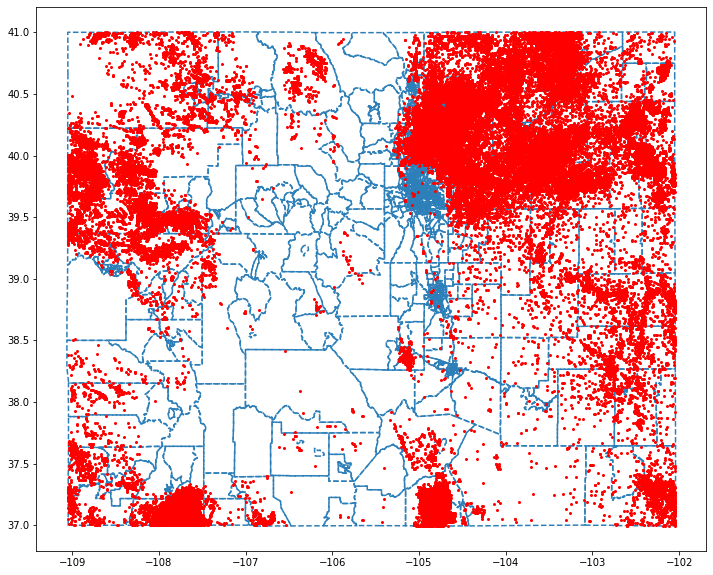

In [44]:
#Visualizing census tracts (not blocks--far too many) and wells, to get a lay of the land
fig = plt.figure(figsize=(12,10))

for tract in tracts.geometry:
    if isinstance(tract, Polygon):
        lons, lats = tract.exterior.xy
        plt.plot(lons, lats, '--', c=(44/255,127/255,184/255))
    elif isinstance(tract, MultiPolygon):
        for poly in tract:
            lons, lats = poly.exterior.xy
            plt.plot(lons, lats, '--', c=(44/255,127/255,184/255))
            
plt.plot(oil_gas.long, oil_gas.lat, 'or', markersize=2)

## Step 1: building buffers

In [10]:
#Aligning CRS; aligning well CRS to block CRS
oil_gas = oil_gas.to_crs(block_shapes_pop.crs)

<font color = 'red'> Questions:
- Is this approach to buffering with degrees correct? Or is this making an oval?
- Important to adjust the lat_radians for each well? How much difference would this make?
- Is this the appropriate method of recasting from one CRS to another?
</font>

In [185]:
# Calculate 1-km buffer distance
lat_radians = 39.7392 * np.pi/180
buff_dist_1km = 1/(111.32*np.cos(lat_radians))

In [12]:
#Making circular buffers
oil_gas_250m_buffer = oil_gas.geometry.apply(lambda x: x.buffer(buff_dist_1km*.25))
oil_gas_500m_buffer = oil_gas.geometry.apply(lambda x: x.buffer(buff_dist_1km*.5))
oil_gas_750m_buffer = oil_gas.geometry.apply(lambda x: x.buffer(buff_dist_1km*.75))
oil_gas_1000m_buffer = oil_gas.geometry.apply(lambda x: x.buffer(buff_dist_1km))

In [13]:
#Making ring buffers -- this is what we'll actually use in the analysis
oil_gas_250m_500m_buffer = oil_gas_500m_buffer - oil_gas_250m_buffer
oil_gas_500m_750m_buffer = oil_gas_750m_buffer - oil_gas_500m_buffer
oil_gas_750m_1000m_buffer = oil_gas_1000m_buffer - oil_gas_750m_buffer

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: '-' operator will be deprecated. Use the 'difference' method instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: '-' operator will be deprecated. Use the 'difference' method instead.
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: '-' operator will be deprecated. Use the 'difference' method instead.
  after removing the cwd from sys.path.


## Step 2: determining overlap of buffers with blocks

In [56]:
#0-250m buffer intersects with which block groups?
oil_gas_250m_buffer = gpd.GeoDataFrame(oil_gas_250m_buffer)
oil_gas_250m_buffer.crs = tracts.crs
oil_gas_250m_buffer.reset_index(inplace=True)

timer = time.time()
intersection_250m = gpd.overlay(oil_gas_250m_buffer, block_shapes_pop, how='intersection')
timer2 = time.time()
timer2-timer

141.85288906097412

In [65]:
#250-500m buffer intersects with which block groups?
oil_gas_250m_500m_buffer = gpd.GeoDataFrame(oil_gas_250m_500m_buffer).reset_index(drop=True)
oil_gas_250m_500m_buffer.columns = ['index','geometry']
oil_gas_250m_500m_buffer.crs = block_shapes_pop.crs ##??

timer = time.time()
intersection_500m = gpd.overlay(oil_gas_250m_500m_buffer, block_shapes_pop, how='intersection')
timer2 = time.time()
timer2-timer

205.61743474006653

In [66]:
#500-750m buffer intersects with which block groups?
oil_gas_500m_750m_buffer = gpd.GeoDataFrame(oil_gas_500m_750m_buffer).reset_index(drop=True)
oil_gas_500m_750m_buffer.columns = ['index','geometry']
oil_gas_500m_750m_buffer.crs = block_shapes_pop.crs

timer = time.time()
intersection_750m = gpd.overlay(oil_gas_500m_750m_buffer, block_shapes_pop, how='intersection')
timer2 = time.time()
timer2-timer

245.33547711372375

In [67]:
#750-1000m buffer intersects with which block groups?
oil_gas_750m_1000m_buffer = gpd.GeoDataFrame(oil_gas_750m_1000m_buffer).reset_index(drop=True)
oil_gas_750m_1000m_buffer.columns = ['index','geometry']
oil_gas_750m_1000m_buffer.crs = block_shapes_pop.crs

timer = time.time()
intersection_1000m = gpd.overlay(oil_gas_750m_1000m_buffer, block_shapes_pop, how='intersection')
timer2 = time.time()
timer2-timer

301.4157989025116

In [68]:
#Saving results, as this takes a while to re-run if it crashes
intersection_250m.to_file("intersection_250m.shp")
intersection_500m.to_file("intersection_500m.shp")
intersection_750m.to_file("intersection_750m.shp")
intersection_1000m.to_file("intersection_1000m.shp")

## Step 3: Finding buffer distance that *first* overlaps each block

<font color = 'red'> Questions:
- Does this approach work? Does it  fail to account for any idiosyncratic situations?
</font>

In [ ]:
#For each well, figuring out how many and which blocks its buffer overlaps with
overlap_250 = intersection_250m.groupby('index')['GEOID10'].agg({'blocks_250': lambda x: set(x)})
overlap_500 = intersection_500m.groupby('index')['GEOID10'].agg({'blocks_500': lambda x: set(x)})
overlap_750 = intersection_750m.groupby('index')['GEOID10'].agg({'blocks_750': lambda x: set(x)})
overlap_1000 = intersection_1000m.groupby('index')['GEOID10'].agg({'blocks_1000': lambda x: set(x)})

In [110]:
#Compile into dataframe with index as the well number and a column for each buffer distance
df = pd.concat([overlap_250, overlap_500, overlap_750, overlap_1000], axis=1)

In [146]:
#Replacing any NaNs from join with empty sets
for col in df.columns:
    df.loc[df[col].isnull(), col] = set()

In [179]:
#For each well, calculates the number of times the nearest populated block is in a given buffer

timer = time.time()
result = np.zeros(4)
for a, b, c, d in zip(df.blocks_250, df.blocks_500, df.blocks_750, df.blocks_1000): #for each well that is within 1km of any populated block group:
    each_well = np.array([len(a), len(b.difference(a)), len(c.difference(b)), len(d.difference(c))])
    result = np.vstack([result, each_well])
    
output = output.astype(int)
timer2 = time.time()
print((timer2 - timer) / 60)

result = result[1:]
result = pd.DataFrame(result, columns=['blocks_250m','blocks_250-500m','blocks_500-750m','blocks_750-1000m'],
            index=df.index)

0.4152592976888021


# Visual check: Plotting the results of overlay with zoomed-in well buffers and block groups

In [29]:
#Bounding box to zoom in on section of CO
lat_bounds = [39, 39.05]
lon_bounds = [-103.65, -103.6]
lat_point_list = [lat_bounds[0], lat_bounds[1], lat_bounds[1], lat_bounds[0]]
lon_point_list = [lon_bounds[0], lon_bounds[0], lon_bounds[1], lon_bounds[1]]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = intersection_250m.crs
bbox = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[bbox_geom])  

In [32]:
graphing_250m = gpd.overlay(intersection_250m, bbox, how='intersection')
graphing_250m_buffer = gpd.overlay(oil_gas_250m_buffer, bbox, how='intersection')
graphing_blocks = gpd.overlay(block_shapes_pop, bbox, how='intersection')

In [34]:
graphing_250m_buffer

,index,geometry
0,2239,"POLYGON ((-103.61520 39.00309, -103.61521 39.0..."
1,9711,"POLYGON ((-103.62238 39.00899, -103.62239 39.0..."
2,55668,"POLYGON ((-103.63714 39.01989, -103.63715 39.0..."
3,82683,"POLYGON ((-103.61547 39.04786, -103.61548 39.0..."


In [42]:
graphing_250m_buffer

,index,geometry
0,2239,"POLYGON ((-103.61520 39.00309, -103.61521 39.0..."
1,9711,"POLYGON ((-103.62238 39.00899, -103.62239 39.0..."
2,55668,"POLYGON ((-103.63714 39.01989, -103.63715 39.0..."
3,82683,"POLYGON ((-103.61547 39.04786, -103.61548 39.0..."


In [40]:
graphing_blocks

,NAME10,geometry
0,Block 2326,"POLYGON ((-103.65000 39.02481, -103.64987 39.0..."
1,Block 2329,"POLYGON ((-103.64849 39.05000, -103.64844 39.0..."
2,Block 2349,"POLYGON ((-103.60899 39.00000, -103.60900 39.0..."


In [41]:
graphing_250m

,index,NAME10,geometry
0,2239,Block 2326,"POLYGON ((-103.61520 39.00309, -103.61521 39.0..."
1,9711,Block 2326,"POLYGON ((-103.62238 39.00899, -103.62239 39.0..."
2,55668,Block 2326,"MULTIPOLYGON (((-103.63714 39.01989, -103.6371..."
3,82683,Block 2326,"POLYGON ((-103.61547 39.04786, -103.61548 39.0..."
4,55668,Block 2329,"POLYGON ((-103.63969 39.01700, -103.63977 39.0..."


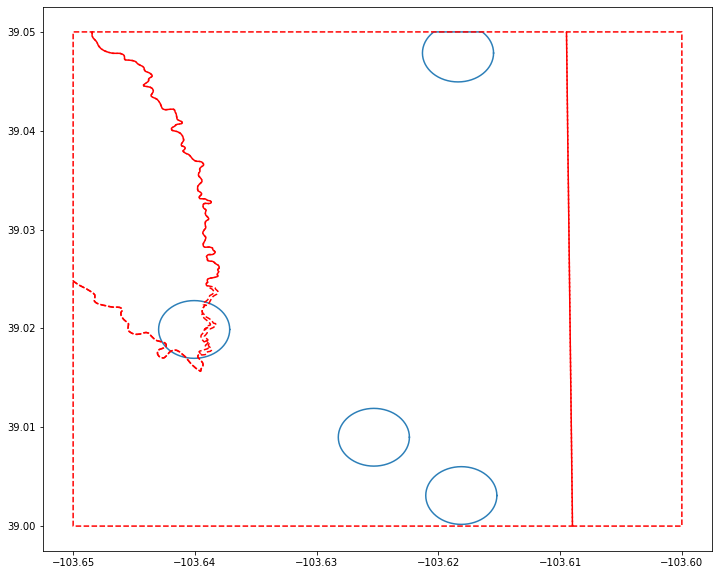

In [39]:
fig = plt.figure(figsize=(12,10))

for buff in graphing_250m_buffer.geometry:
    if isinstance(buff, Polygon):
        lons, lats = buff.exterior.xy
        plt.plot(lons, lats, '-', c=(44/255,127/255,184/255))
    elif isinstance(buff, MultiPolygon):
        for poly in buff:
            lons, lats = poly.exterior.xy
            plt.plot(lons, lats, '-', c=(44/255,127/255,184/255))
            
for block in graphing_blocks.geometry:
    if isinstance(block, Polygon):
        lons, lats = block.exterior.xy
        plt.plot(lons, lats, '--', c='red')
    elif isinstance(block, MultiPolygon):
        for poly in buff:
            lons, lats = poly.exterior.xy
            plt.plot(lons, lats, '--', c='red')

# Generalizing distance calculation between tract and oil/gas equipment
Separate analysis in case useful to demonstrate how to calculate the distance between every well and the centroid of every block (or, here, tract) using matrices

In [ ]:
#Quick and dirty extraction of centroid of census tracts
tracts['long'] = tracts['geometry'].apply(lambda lamb: lamb.centroid.x)
tracts['lat'] = tracts['geometry'].apply(lambda lamb: lamb.centroid.y)

#Separating lats/lons for tracts and og equipment
tract_lat = np.array(tracts['lat'])
tract_lon = np.array(tracts['long'])
og_lat = np.array(oil_gas['lat'])
og_lon = np.array(oil_gas['long'])

#Multi-step process to avoid populating huge matrix with distance calculations:
#(breaking down [(lat_a - lat_b)^2 + (lon_a - lon_b)^2]^.5 )
#0. Create tiled matrices to enable matrix operations
#1. Subtract and square latitudes
#2. Subtract and square longitudes
#3. Sum the differences and take the square root

#Tiling example
x = np.array([1,2,3,4,5])
y = np.array([7,8])
print(np.tile(y, (len(x),1)))
print(np.tile(x, (len(y),1)).T)

#Creating tiled latitude matrices for tracts and og latitudes
tract_lat_tile = np.tile(tract_lat, (len(og_lat),1))
og_lat_tile = np.tile(og_lat, (len(tract_lat),1)).T
assert tract_lat_tile.shape == og_lat_tile.shape

#Creating tiled latitude matrices for tracts and og latitudes
tract_lon_tile = np.tile(tract_lon, (len(og_lon),1))
og_lon_tile = np.tile(og_lon, (len(tract_lon),1)).T
assert tract_lon_tile.shape == og_lon_tile.shape

#Subtract and square lats and lons
squared_lat_diffs = np.square(np.subtract(tract_lat_tile, og_lat_tile))
squared_lon_diffs = np.square(np.subtract(tract_lon_tile, og_lon_tile))
assert squared_lat_diffs.shape == squared_lon_diffs.shape

#Sum and square-root the differences
#Now we can sort / further manipulate the distance matrix to get the products we need!
dist_matrix = np.sqrt(np.add(squared_lat_diffs, squared_lon_diffs))